In [ ]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

In [ ]:
import pandas as pd

df = pd.read_csv('keypointsSample.csv')
df.shape

(448, 35)

In [ ]:
NUM_CLASSES = 4

In [ ]:
dataset = 'keypointsSample.csv'

model_save_path = 'keypoint_classifier.keras'
tflite_save_path = 'keypoint_classifier.tflite'

In [ ]:
import pandas as pd

# Determine the maximum number of columns
max_columns = max(open(dataset, 'r'), key=lambda x: x.count(',')).count(',')

# Read the CSV with the maximum number of columns
df = pd.read_csv(dataset, header=None, names=list(range(max_columns)))


In [ ]:
# import pandas as pd

# # Load your CSV file, skipping the first row (which is usually the header)
# df = pd.read_csv('keypoint.csv')

# # Now remove the first row of data (which was originally the second row)
# df = df.iloc[1:]

# # # # # Convert all columns to numeric, non-numeric values will become NaN
# df = df.apply(pd.to_numeric, errors='coerce')
# df = df.drop(2148)
# # # # # Remove rows with NaN values (non-numeric values)
# df = df.dropna()

# # # # # Export the DataFrame to a new CSV file without the header
# df.to_csv('keypoint1.csv', index=False, header=False)


In [ ]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, 35)))

In [ ]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((34, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])



In [ ]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_24 (Dropout)        (None, 34)                0         
                                                                 
 dense_36 (Dense)            (None, 20)                700       
                                                                 
 dropout_25 (Dropout)        (None, 20)                0         
                                                                 
 dense_37 (Dense)            (None, 10)                210       
                                                                 
 dense_38 (Dense)            (None, 4)                 44        
                                                                 
Total params: 954 (3.73 KB)
Trainable params: 954 (3.73 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [ ]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)



In [ ]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
1/3 [=========>....................] - ETA: 1s - loss: 1.4372 - accuracy: 0.2031
Epoch 1: saving model to keypoint_classifier.keras
3/3 [==============================] - 1s 158ms/step - loss: 1.4315 - accuracy: 0.2173 - val_loss: 1.4099 - val_accuracy: 0.1858
Epoch 2/1000
1/3 [=========>....................] - ETA: 0s - loss: 1.4234 - accuracy: 0.2344
Epoch 2: saving model to keypoint_classifier.keras
3/3 [==============================] - 0s 37ms/step - loss: 1.4159 - accuracy: 0.2292 - val_loss: 1.3991 - val_accuracy: 0.1858
Epoch 3/1000
1/3 [=========>....................] - ETA: 0s - loss: 1.4122 - accuracy: 0.1953
Epoch 3: saving model to keypoint_classifier.keras
3/3 [==============================] - 0s 32ms/step - loss: 1.4114 - accuracy: 0.2202 - val_loss: 1.3874 - val_accuracy: 0.1858
Epoch 4/1000
1/3 [=========>....................] - ETA: 0s - loss: 1.4213 - accuracy: 0.2344
Epoch 4: saving model to keypoint_classifier.keras
3/3 [==============================

In [ ]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=16)

8/8 [==============================] - 0s 3ms/step - loss: 0.0264 - accuracy: 1.0000


In [ ]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [ ]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 109ms/step
[2.3891346e-04 3.2961178e-03 9.9439079e-01 2.0742372e-03]
2


4/4 [==============================] - 0s 3ms/step


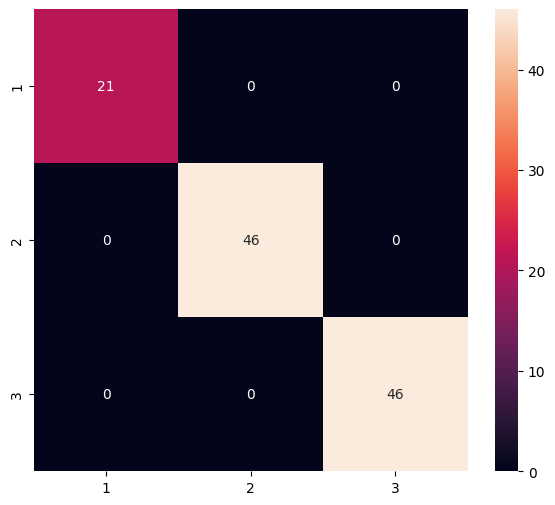

Classification Report
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        21
           2       1.00      1.00      1.00        46
           3       1.00      1.00      1.00        46

    accuracy                           1.00       113
   macro avg       1.00      1.00      1.00       113
weighted avg       1.00      1.00      1.00       113



In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)

    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)

    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()

    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

In [ ]:
# Save as a model dedicated to inference
model.save(model_save_path,save_format='tf', include_optimizer=False)

In [ ]:
model = tf.keras.models.load_model('keypoint_classifier.keras')

tflite_save_path = 'keypoint_classifier.tflite'

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)


5984

In [ ]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [ ]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [ ]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [ ]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: user 202 µs, sys: 0 ns, total: 202 µs
Wall time: 425 µs


In [ ]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[2.3891369e-04 3.2961175e-03 9.9439079e-01 2.0742370e-03]
2
